In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# load the sales data set
sales_data = pd.read_csv('../../../../Data/SalesData.csv')
sales_data.head()

sales_data = sales_data[sales_data['Category'] == 'Needles'] 


pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Pharmacy 10,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
14,1-12-2015,12,4,2015,1,Mesotherapy Needles,Needles,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
39,1-1-2016,1,1,2016,1,Mesotherapy Needles,Needles,Pharmacy 2,NorthWest,0,...,0,0,0,0,1,0,0,0,0,0
40,1-1-2016,1,1,2016,1,Mesotherapy Needles,Needles,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
41,1-1-2016,1,1,2016,1,Mesotherapy Needles,Needles,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
79,1-2-2016,2,1,2016,1,Mesotherapy Needles,Needles,Pharmacy 2,"Scotland, Newcastle",0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68074,1-3-2022,3,1,2022,1,Skin Booster Needles,Needles,Pharmacy 3,SouthEast,0,...,0,0,0,0,0,0,0,0,1,0
68087,1-3-2022,3,1,2022,6,Skin Booster Needles,Needles,Pharmacy 10,Outside London the rest,1,...,0,0,0,0,0,0,1,0,0,0
68092,1-3-2022,3,1,2022,1,Skin Booster Needles,Needles,Pharmacy 10,Ireland & Northern Ireland,1,...,0,1,0,0,0,0,0,0,0,0
68130,1-3-2022,3,1,2022,1,Mesotherapy Needles,Needles,Pharmacy 10,Ireland & Northern Ireland,1,...,0,1,0,0,0,0,0,0,0,0


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Pharmacy 10',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 4',
 'Pharmacy 5',
 'Pharmacy 9',
 'Mesotherapy Needles',
 'Skin Booster Needles',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 4' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Mesotherapy Needles' : 'sum',
    'Skin Booster Needles' : 'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

# print(sales_data_lagged)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)

sales_data_lagged['Date'] = pd.to_datetime(sales_data_lagged['Date'], format='%d-%m-%Y')


#X_train, X_test, y_train, y_test = train_test_split(sales_data_lagged.loc[:,sales_data_lagged.columns!='Qty'], sales_data_lagged.loc[:,['Date', 'Qty']], test_size=0.2, random_state=42)
X = sales_data_lagged.loc[(sales_data_lagged['Date'] < '2019-01-01')]
y = sales_data_lagged.loc[(sales_data_lagged['Date'] >= '2019-01-01') & (sales_data_lagged['Date']<= '2019-12-01')]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X.loc[:,X.columns!='Qty']
X_test = y.loc[:,y.columns!='Qty']
y_train = X.loc[:,X.columns=='Qty']
y_test = y.loc[:,y.columns=='Qty']



In [4]:
y

,Date,Qty,Pharmacy 2,Pharmacy 3,Pharmacy 4,Pharmacy 5,Pharmacy 9,Pharmacy 10,Mesotherapy Needles,Skin Booster Needles,...,"Scotland, Newcastle",SouthEast,SouthWest,Qty_lag_1,Qty_lag_2,Qty_lag_3,Qty_lag_4,Qty_lag_5,Qty_lag_6,Qty_lag_7
9,2019-10-01,4,2,0,2,0,0,0,2,2,...,3,0,0,1.0,1.0,2.0,6.0,6.0,20.0,8.0
15,2019-11-01,65,3,11,2,1,0,0,4,13,...,0,6,1,14.0,2.0,2.0,54.0,45.0,4.0,1.0
21,2019-12-01,3,1,0,1,0,0,0,1,1,...,0,0,0,25.0,2.0,1.0,29.0,17.0,65.0,14.0
26,2019-02-01,7,1,0,1,0,0,0,1,1,...,1,0,0,2.0,1.0,8.0,36.0,3.0,25.0,2.0
31,2019-03-01,1,1,0,0,0,0,0,1,0,...,0,0,0,2.0,9.0,9.0,43.0,7.0,2.0,1.0
37,2019-04-01,3,3,0,0,0,0,0,3,0,...,0,0,1,1.0,5.0,17.0,32.0,32.0,1.0,2.0
42,2019-05-01,2,1,0,1,0,0,0,1,1,...,0,0,1,3.0,2.0,41.0,1.0,3.0,1.0,5.0
48,2019-06-01,4,4,0,0,0,0,0,4,0,...,0,0,1,2.0,1.0,1.0,59.0,28.0,2.0,3.0
52,2019-07-01,5,3,0,1,0,0,0,3,1,...,0,0,2,3.0,118.0,8.0,4.0,2.0,1.0,1.0
58,2019-08-01,12,3,0,4,0,0,0,3,4,...,3,0,2,3.0,1.0,2.0,35.0,17.0,5.0,3.0


In [5]:
# train a random forest model

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

criterion = ['squared_error', 'friedman_mse', 'poisson']
max_depth = [5, 10]
min_samples_leaf = [1, 2]
max_features = ['log2', 'sqrt']

random_grid_rfr = {
    'criterion' : criterion,
    'max_depth' : max_depth,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features
}
# rfr = RandomForestRegressor()
# rfr_random = RandomizedSearchCV(
#     estimator=rfr,
#     param_distributions=random_grid_rfr,
#     n_iter=10,
#     cv=5,
#     verbose=5,
#     random_state=0
# )
rfr = RandomForestRegressor()
rfr_random = GridSearchCV(
    estimator=rfr,
    param_grid=random_grid_rfr,
    cv=5,
    verbose=5
)

In [6]:
rfr_random.fit(X_train.iloc[:, 2:], y_train['Qty'])


# make predictions for the test data
predictions = rfr_random.predict(X_test.iloc[:, 2:])

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.961 total time=   0.1s
[CV 2/5] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.115 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.113 total time=   0.1s
[CV 4/5] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=-0.729 total time=   0.1s
[CV 5/5] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=-0.533 total time=   0.1s
[CV 1/5] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2;, score=0.295 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2;, score=-0.041 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, max_features=log2, min_samples

In [7]:
# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - y_test['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

# calculate the mean squared error
mse = mean_squared_error(y_test['Qty'], predictions)
print('MSE:', mse)

# calculate the r2 score
r2_score = r2_score(y_test['Qty'], predictions)
print('R^2 Score:', r2_score)

# calculate explained variance score
explained_variance_score = explained_variance_score(y_test['Qty'], predictions)
print('Explained Variance Score:', explained_variance_score)

# calculate max error
max_error = max_error(y_test['Qty'], predictions)
print('Max Error:', max_error)


print([X_test['Date'].values, y_test['Qty'].values, predictions])

RMSE: 15.71176380199967
MSE: 246.85952176982713
R^2 Score: 0.19570245747888726
Explained Variance Score: 0.2846976019725349
Max Error: 51.33
[array(['2019-10-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000'], dtype='datetime64[ns]'), array([ 4, 65,  3,  7,  1,  3,  2,  4,  5, 12, 12], dtype=int64), array([ 9.90928571, 13.67      ,  1.912     ,  1.96461905,  1.50325505,
        2.59989394,  2.89752778,  3.8275    ,  2.36144048, 11.0425    ,
        8.82196429])]


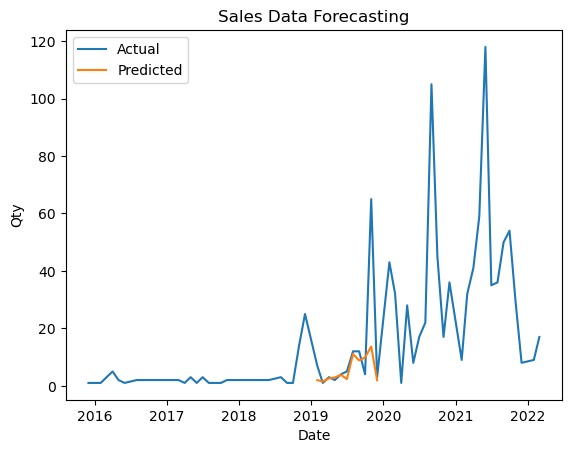

In [8]:

sales_data_lagged['predicted_quantity'] = pd.Series(predictions, index=y_test.index)
sales_data_lagged= sales_data_lagged.sort_values(by=['Date'])

# plot the actual and predicted quantities against date
plt.plot(sales_data_lagged['Date'], sales_data_lagged['Qty'], label='Actual')
plt.plot(sales_data_lagged['Date'], sales_data_lagged['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [9]:
rfr_random.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

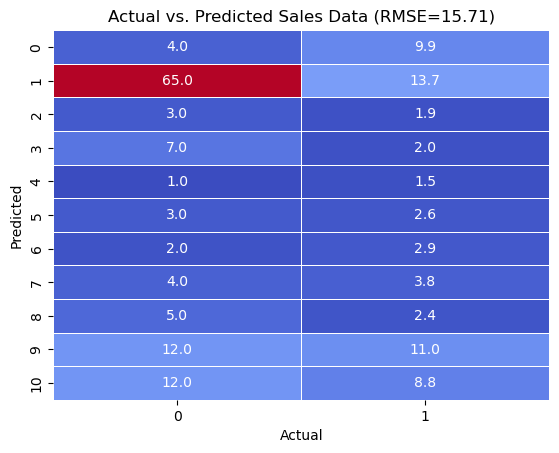

In [10]:
matrix_data = np.column_stack((y_test['Qty'].values, predictions))

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()